In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

In [2]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [3]:
base_dir = '/content/dohai90/datasets/dogs_vs_cats_data/small_set'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count,))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i*batch_size : (i+1)*batch_size] = features_batch
        labels[i*batch_size : (i+1)*batch_size] = labels_batch
        i+=1
        if i * batch_size >= sample_count:
            break
            
    return features, labels   

train_features, train_labels = extract_features(train_dir, 2000)
val_features, val_labels = extract_features(val_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)    

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
# flatten extracted features before feeding into FC layers
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
val_features = np.reshape(val_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

# defining and training the FC classifier
model = keras.Sequential()
model.add(keras.layers.Dense(256, activation=keras.activations.relu, input_shape=(4*4*512, )))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation=keras.activations.sigmoid))

model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-5),
              loss=keras.losses.binary_crossentropy,
              metrics=[keras.metrics.binary_accuracy])

history = model.fit(train_features, train_labels,
                    epochs=100,
                    batch_size=batch_size,
                    validation_data=(val_features, val_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/100
2000/2000 [==============================] - 2s 759us/step - loss: 0.6022 - binary_accuracy: 0.6835 - val_loss: 0.4429 - val_binary_accuracy: 0.8160
Epoch 2/100
2000/2000 [==============================] - 1s 374us/step - loss: 0.4377 - binary_accuracy: 0.8020 - val_loss: 0.3619 - val_binary_accuracy: 0.8610
Epoch 3/100
2000/2000 [==============================] - 1s 382us/step - loss: 0.3607 - binary_accuracy: 0.8465 - val_loss: 0.3286 - val_binary_accuracy: 0.8660
Epoch 4/100
2000/2000 [==============================] - 1s 396us/step - loss: 0.3166 - binary_accuracy: 0.8710 - val_loss: 0.2985 - val_binary_accuracy: 0.8850
Epoch 5/100
2000/2000 [==============================] - 1s 372us/step - loss: 0.2875 - binary_accuracy: 0.8840 - val_loss: 0.2845 - val_binary_accuracy: 0.8930
Epoch 6/100
2000/2000 [==============================] - 1s 364us/step - loss: 0.2601 - binary_accuracy: 0.8995 - val_loss: 0.2693 - val_binary_acc

2000/2000 [==============================] - 1s 373us/step - loss: 0.0373 - binary_accuracy: 0.9920 - val_loss: 0.2656 - val_binary_accuracy: 0.9030
Epoch 52/100
2000/2000 [==============================] - 1s 378us/step - loss: 0.0372 - binary_accuracy: 0.9925 - val_loss: 0.2726 - val_binary_accuracy: 0.9010
Epoch 53/100
2000/2000 [==============================] - 1s 379us/step - loss: 0.0341 - binary_accuracy: 0.9960 - val_loss: 0.2669 - val_binary_accuracy: 0.9000
Epoch 54/100
2000/2000 [==============================] - 1s 374us/step - loss: 0.0315 - binary_accuracy: 0.9970 - val_loss: 0.2767 - val_binary_accuracy: 0.9030
Epoch 55/100
2000/2000 [==============================] - 1s 383us/step - loss: 0.0310 - binary_accuracy: 0.9950 - val_loss: 0.2774 - val_binary_accuracy: 0.9010
Epoch 56/100
2000/2000 [==============================] - 1s 371us/step - loss: 0.0289 - binary_accuracy: 0.9960 - val_loss: 0.2841 - val_binary_accuracy: 0.9010
Epoch 57/100
2000/2000 [=================

In [5]:
history.history.keys()

dict_keys(['val_loss', 'binary_accuracy', 'loss', 'val_binary_accuracy'])

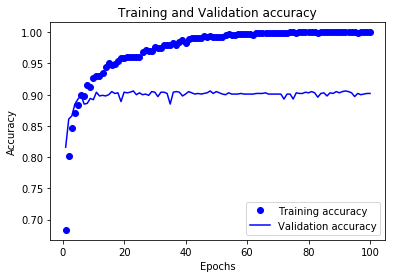

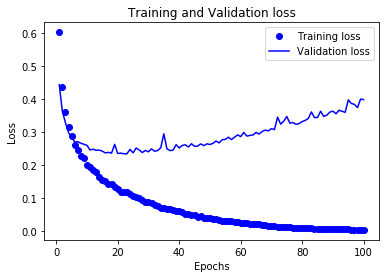

In [6]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [7]:
# Feature extraction with data augmentation
model = keras.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation=keras.activations.relu))
model.add(keras.layers.Dense(1, activation=keras.activations.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [8]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150),
                                                    batch_size=20,
                                                    class_mode='binary')
val_generator = val_datagen.flow_from_directory(val_dir, 
                                                target_size=(150, 150),
                                                batch_size=20,
                                                class_mode='binary')

model.compile(optimizer=keras.optimizers.RMSprop(lr=2e-5),
              loss=keras.losses.binary_crossentropy,
              metrics=[keras.metrics.binary_accuracy])

history = model.fit_generator(train_generator,
                              epochs=100,
                              steps_per_epoch=100,
                              validation_data=val_generator,
                              validation_steps=50)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 33s 330ms/step - loss: 0.5891 - binary_accuracy: 0.6940 - val_loss: 0.4485 - val_binary_accuracy: 0.8320
Epoch 2/100
100/100 [==============================] - 30s 302ms/step - loss: 0.4775 - binary_accuracy: 0.7875 - val_loss: 0.3666 - val_binary_accuracy: 0.8630
Epoch 3/100
100/100 [==============================] - 29s 289ms/step - loss: 0.4311 - binary_accuracy: 0.8080 - val_loss: 0.3288 - val_binary_accuracy: 0.8660
Epoch 4/100
100/100 [==============================] - 31s 310ms/step - loss: 0.3948 - binary_accuracy: 0.8270 - val_loss: 0.3033 - val_binary_accuracy: 0.8820
Epoch 5/100
100/100 [==============================] - 29s 288ms/step - loss: 0.3728 - binary_accuracy: 0.8365 - val_loss: 0.3052 - val_binary_accuracy: 0.8750
Epoch 6/100
100/100 [==============================] - 23s 234ms/step - loss: 0.3669 - binary_accuracy: 0.8350 - val

100/100 [==============================] - 25s 246ms/step - loss: 0.2531 - binary_accuracy: 0.8935 - val_loss: 0.2332 - val_binary_accuracy: 0.9070
Epoch 52/100
100/100 [==============================] - 22s 221ms/step - loss: 0.2582 - binary_accuracy: 0.8955 - val_loss: 0.2465 - val_binary_accuracy: 0.8970
Epoch 53/100
100/100 [==============================] - 23s 235ms/step - loss: 0.2530 - binary_accuracy: 0.8905 - val_loss: 0.2333 - val_binary_accuracy: 0.9090
Epoch 54/100
100/100 [==============================] - 28s 279ms/step - loss: 0.2492 - binary_accuracy: 0.8915 - val_loss: 0.2372 - val_binary_accuracy: 0.9030
Epoch 55/100
100/100 [==============================] - 24s 245ms/step - loss: 0.2645 - binary_accuracy: 0.8855 - val_loss: 0.2364 - val_binary_accuracy: 0.9050
Epoch 56/100
100/100 [==============================] - 30s 300ms/step - loss: 0.2503 - binary_accuracy: 0.8870 - val_loss: 0.2406 - val_binary_accuracy: 0.9080
Epoch 57/100
100/100 [=========================

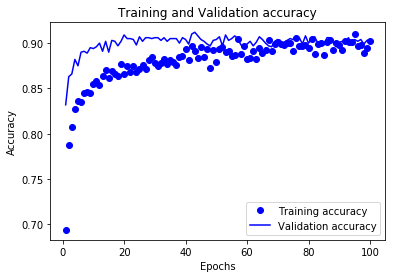

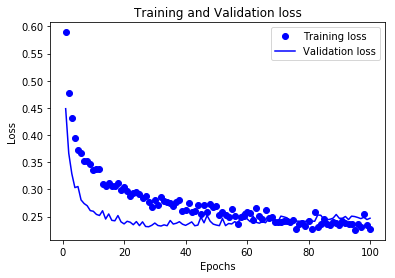

In [10]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [11]:
fine_tune_layers = ['block5_conv{}'.format(i) for i in range(1, 4)]
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name in fine_tune_layers:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
model.compile(optimizer=keras.optimizers.RMSprop(lr=1e-5),
              loss=keras.losses.binary_crossentropy,
              metrics=[keras.metrics.binary_accuracy])

history = model.fit_generator(train_generator,
                              epochs=100,
                              steps_per_epoch=100,
                              validation_data=val_generator,
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 32s 323ms/step - loss: 0.2423 - binary_accuracy: 0.8990 - val_loss: 0.2391 - val_binary_accuracy: 0.9090
Epoch 2/100
100/100 [==============================] - 29s 294ms/step - loss: 0.2373 - binary_accuracy: 0.9020 - val_loss: 0.2373 - val_binary_accuracy: 0.9120
Epoch 3/100
100/100 [==============================] - 26s 259ms/step - loss: 0.2193 - binary_accuracy: 0.9075 - val_loss: 0.2062 - val_binary_accuracy: 0.9140
Epoch 4/100
100/100 [==============================] - 24s 243ms/step - loss: 0.2009 - binary_accuracy: 0.9140 - val_loss: 0.2244 - val_binary_accuracy: 0.9190
Epoch 5/100
100/100 [==============================] - 28s 275ms/step - loss: 0.1838 - binary_accuracy: 0.9230 - val_loss: 0.2674 - val_binary_accuracy: 0.9010
Epoch 6/100
100/100 [==============================] - 23s 231ms/step - loss: 0.1824 - binary_accuracy: 0.9225 - val_loss: 0.2156 - val_binary_accuracy: 0.9160
Epoch 7/100
100/100 [===================

Epoch 52/100
100/100 [==============================] - 26s 264ms/step - loss: 0.0315 - binary_accuracy: 0.9885 - val_loss: 0.2634 - val_binary_accuracy: 0.9420
Epoch 53/100
100/100 [==============================] - 25s 251ms/step - loss: 0.0335 - binary_accuracy: 0.9865 - val_loss: 0.2754 - val_binary_accuracy: 0.9300
Epoch 54/100
100/100 [==============================] - 26s 258ms/step - loss: 0.0209 - binary_accuracy: 0.9930 - val_loss: 0.3193 - val_binary_accuracy: 0.9260
Epoch 55/100
100/100 [==============================] - 27s 272ms/step - loss: 0.0355 - binary_accuracy: 0.9890 - val_loss: 0.2649 - val_binary_accuracy: 0.9320
Epoch 56/100
100/100 [==============================] - 24s 241ms/step - loss: 0.0477 - binary_accuracy: 0.9850 - val_loss: 0.2602 - val_binary_accuracy: 0.9320
Epoch 57/100
100/100 [==============================] - 25s 250ms/step - loss: 0.0359 - binary_accuracy: 0.9885 - val_loss: 0.3140 - val_binary_accuracy: 0.9310
Epoch 58/100
100/100 [============

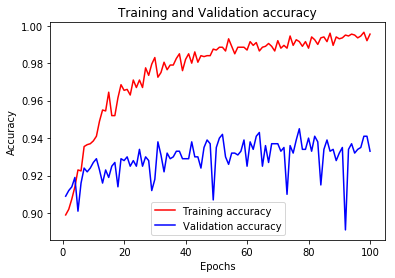

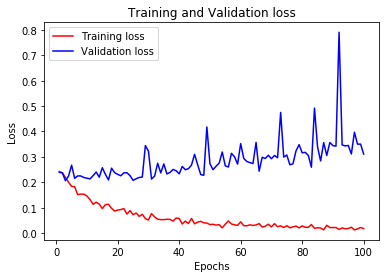

In [13]:
acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')
test_loss, test_accuracy = model.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_accuracy)

Found 1000 images belonging to 2 classes.
test accuracy: 0.943999993801117
